# Iniciando PySpark

### Realiza instalação do pyspark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Abrindo a sessão spark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.appName("Project_Spark") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()



### Imports

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from pyspark.sql.window import Window
import pandas as pd
import numpy as np

# melhor visualização do dataframe
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# # Session builder
# spark = SparkSession.builder.appName('sparkdf').getOrCreate()

# Obtendo dataframe

### Importando csv

In [ ]:
nome_arq = "owid-covid-data.csv"

In [ ]:
df = spark.read.format('csv').\
options(header='true', \
inferschema='true').\
load(f'{nome_arq}',header=True)

# Trabalhando com os dados

In [ ]:
df.select('iso_code', 'continent', 'location',
          'date', 'total_cases', 'new_cases')\
          .show()

+--------+---------+-----------+-------------------+-----------+---------+
|iso_code|continent|   location|               date|total_cases|new_cases|
+--------+---------+-----------+-------------------+-----------+---------+
|     AFG|     Asia|Afghanistan|2020-02-24 00:00:00|        5.0|      5.0|
|     AFG|     Asia|Afghanistan|2020-02-25 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-26 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-27 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-28 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-29 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-01 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-02 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-03 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-04 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afgha

### Obtenção do total de casos por população de cada país ao longo de 2020 e 2021 

In [ ]:
total_mundo = df.select('iso_code', 'total_cases', 'population')\
  .filter(f.col('date') == '2021-12-31')\
  .distinct()\
  .orderBy('iso_code')

total_mundo = total_mundo.withColumn('casos_por_populacao', 
                                     f.col('total_cases')/f.col('population'))\
                                     .orderBy(f.col('casos_por_populacao')\
                                              .desc())

total_mundo.show()

+--------+-----------+-----------+-------------------+
|iso_code|total_cases| population|casos_por_populacao|
+--------+-----------+-----------+-------------------+
|     AND|    23740.0|    79034.0| 0.3003770529139358|
|     MNE|   170034.0|   627859.0|0.27081558120533433|
|     GIB|     8701.0|    32670.0| 0.2663299663299663|
|     SVK|  1371082.0|  5447622.0|  0.251684496464696|
|     GEO|   934741.0|  3757980.0| 0.2487349586746071|
|     SMR|     8202.0|    33746.0|0.24305102827001718|
|     CZE|  2475729.0| 1.051075E7|0.23554256356587303|
|     SYC|    24788.0|   106470.0|0.23281675589367898|
|     SVN|   464048.0|  2119410.0|0.21895150065348376|
|     MNG|   692621.0|  3347782.0|0.20688951670090824|
|     BHR|   282062.0|  1463265.0|0.19276207658899788|
|     GBR| 1.296469E7| 6.728104E7|0.19269455406753522|
|     ABW|    20461.0|   106536.0|0.19205714500262822|
|     SRB|  1299339.0|  6871547.0|0.18908973481517335|
|     LTU|   524427.0|  2786651.0| 0.1881925651974359|
|     CYP|

### Separação de três países para a comparação. São eles: Brasil, Andorra, que apresentou o maior número de casos por população, e Estados Unidos 

In [ ]:
tres_paises = total_mundo.where(f.col('iso_code').isin({'BRA','USA'}))
tres_paises = tres_paises.union(spark\
                                .createDataFrame([total_mundo.first()]))\
                          .orderBy(f.col('casos_por_populacao').asc())
tres_paises.show()

+--------+-----------+------------+-------------------+
|iso_code|total_cases|  population|casos_por_populacao|
+--------+-----------+------------+-------------------+
|     BRA|2.2291839E7|2.14326223E8|0.10400892008440796|
|     USA|5.4840479E7|3.36997624E8|0.16273253902822768|
|     AND|    23740.0|     79034.0| 0.3003770529139358|
+--------+-----------+------------+-------------------+



### Transformação do dataframe para pandas para que possa posteriormente ser utilizado em gráficos

In [ ]:
pd_tres_paises = tres_paises.toPandas()

### Criação da coluna de nomes com o intuito de disponibilizar no gráfico posteriormente

In [ ]:
pd_tres_paises['nome'] = ['Brasil', 'Estados Unidos', 'Andorra']

### Gráfico de barras comparando a quantidade de casos por população em relação aos três países separados

É possível visualizar através do gráfico que, por mais que o Brasil tenha tido um número elevado de casos por população, o Brasil ainda permaneceu atrás dos Estados Unidos que teve uma quantidade próxima da metade de casos por população do país com maior número.

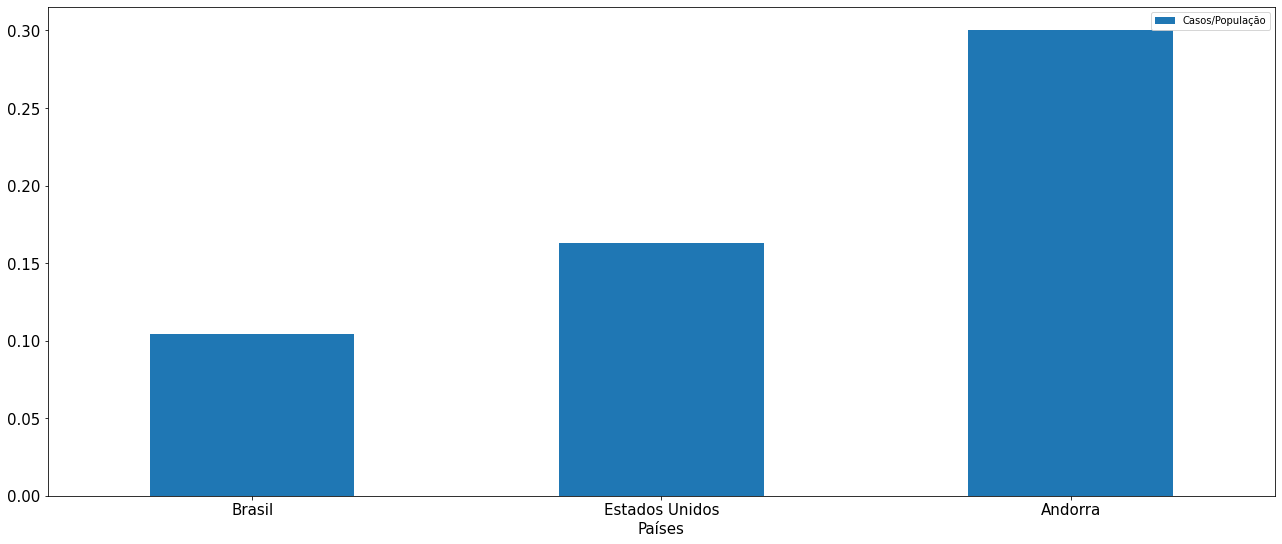

In [ ]:
pd_tres_paises.plot.bar(x='nome', y='casos_por_populacao', 
                     label='Casos/População', figsize=(22,9), fontsize = 15)
plt.xlabel('Países', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

### Criação da uma temp view do dataframe inicial para posteriores manipulações com SQL

In [ ]:
df.createOrReplaceTempView('covid')

### Obtenção da relação de total de mortes por números de casos de todos os países ao longo do período de 2020 e 2021

In [ ]:
total_mundo = spark.sql("""
SELECT 
  iso_code,
  total_cases,
  total_deaths,
  total_deaths/total_cases AS mortes_por_casos
FROM
  covid
WHERE
  date = '2021-12-31'
ORDER BY
  mortes_por_casos
    DESC
""")

total_mundo.show()

+--------+-----------+------------+--------------------+
|iso_code|total_cases|total_deaths|    mortes_por_casos|
+--------+-----------+------------+--------------------+
|     YEM|    10126.0|      1984.0| 0.19593126604779776|
|     VUT|        7.0|         1.0| 0.14285714285714285|
|     PER|  2296831.0|    202690.0| 0.08824767690787873|
|     MEX|  3979723.0|    299428.0|  0.0752384022707108|
|     SDN|    46518.0|      3331.0| 0.07160668988348597|
|     ECU|   549418.0|     33681.0| 0.06130305159277635|
|     SYR|    50278.0|      2897.0| 0.05761963483034329|
|     SOM|    23532.0|      1333.0| 0.05664626891041986|
|     EGY|   385575.0|     21752.0| 0.05641444595733645|
|     TWN|    17029.0|       850.0| 0.04991485113629691|
|     AFG|   158084.0|      7356.0|0.046532223374914604|
|     BIH|   291313.0|     13442.0|  0.0461428085941925|
|     LBR|     6278.0|       287.0| 0.04571519592226824|
|     BGR|   747108.0|     30955.0| 0.04143309936448278|
|     CHN|   115168.0|      463

### Separação de três países para a comparação. São eles: Brasil, Peru, que apresentou o maior número de casos por população depois de Iêmen e Vanuatu que aparentam ter dados subnotificados, e Estados Unidos 

In [ ]:
tres_paises = total_mundo.where(f.col('iso_code').isin({'BRA','USA','PER'}))\
                                .orderBy(f.col('mortes_por_casos').asc())
tres_paises.show()

+--------+-----------+------------+--------------------+
|iso_code|total_cases|total_deaths|    mortes_por_casos|
+--------+-----------+------------+--------------------+
|     USA|5.4840479E7|    825070.0|0.015044908706942549|
|     BRA|2.2291839E7|    619334.0|0.027782992690733144|
|     PER|  2296831.0|    202690.0| 0.08824767690787873|
+--------+-----------+------------+--------------------+



### Transformação do dataframe para pandas para que possa posteriormente ser utilizado em gráficos

In [ ]:
pd_tres_paises = tres_paises.toPandas()

### Criação da coluna de nomes com o intuito de disponibilizar no gráfico posteriormente

In [ ]:
pd_tres_paises['nome'] = ['Estados Unidos', 'Brasil', 'Peru']

### Gráfico de barras comparando a quantidade de mortes por número de casos em relação aos três países separados

Já neste gráfico é possível analisar que, por mais que o Brasil tenha tido uma menor quantidade de casos por população em relação ao Estados Unidos como mostrado no gráfico anterior, o Brasil apresentou uma maior quantidade de óbitos por números de casos, novamente comparado ao Estados Unidos, passando de mais de um quarto do Peru que apresentou um número muito elevado de óbitos por número de casos. O fato de o Brasil ter tido uma quantidade maior do que os Estado Unidos nessa análise, levando em consideração, também, a análise anterior, mostra que o mesmo não soube lidar tão bem com os números de casos o que pode estar atrelado à violação das normas de segurança e de isolamento da população assim como a infraestrutura de hospitais para lidar com inúmeros casos.

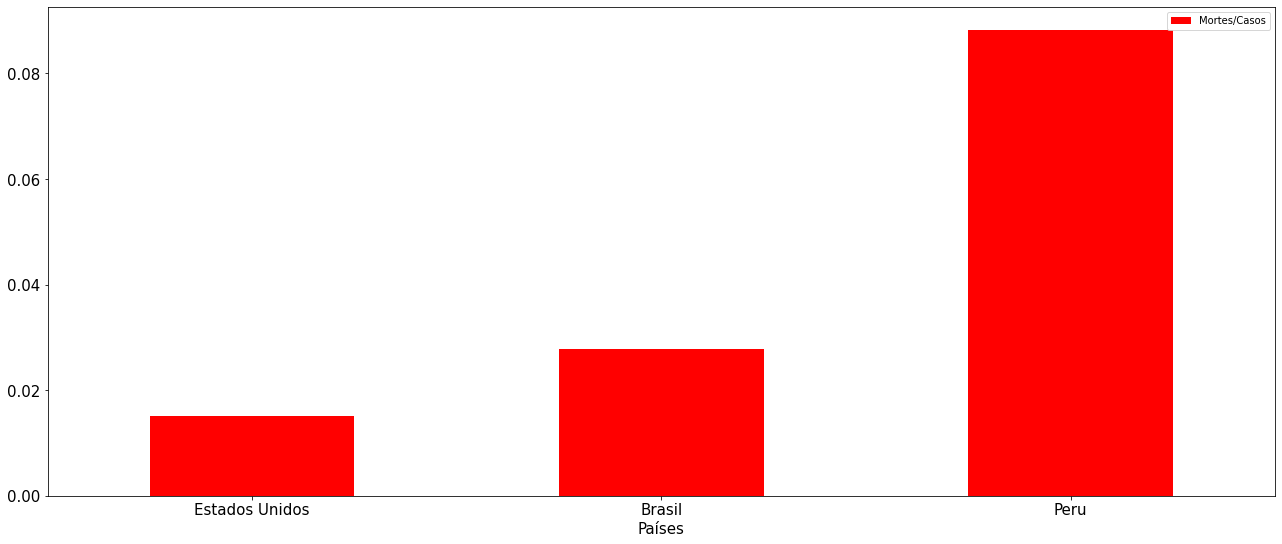

In [ ]:
pd_tres_paises.plot.bar(x='nome', y='mortes_por_casos', 
                     label='Mortes/Casos', color='red', 
                     figsize=(22,9), fontsize = 15)

plt.xlabel('Países', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

### Separação do total de casos do Brasil por mês nos anos de 2020 e 2021

In [ ]:
casos_br = spark.sql("""
SELECT
  distinct(date_format(date, 'MMM/yyyy')) AS Mes_Ano,
  total_cases,
  iso_code
FROM
  covid
WHERE
  date = last_day(date) 
    AND year(date) < 2022
    AND iso_code = 'BRA'
ORDER BY
  total_cases ASC
""")
casos_br.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Feb/2020|        2.0|     BRA|
|Mar/2020|     5717.0|     BRA|
|Apr/2020|    87187.0|     BRA|
|May/2020|   516137.0|     BRA|
|Jun/2020|  1412669.0|     BRA|
|Jul/2020|  2670451.0|     BRA|
|Aug/2020|  3914829.0|     BRA|
|Sep/2020|  4817365.0|     BRA|
|Oct/2020|  5537763.0|     BRA|
|Nov/2020|  6341965.0|     BRA|
|Dec/2020|  7681032.0|     BRA|
|Jan/2021|  9208521.0|     BRA|
|Feb/2021|1.0558091E7|     BRA|
|Mar/2021|1.2763392E7|     BRA|
|Apr/2021|1.4675104E7|     BRA|
|May/2021|1.6557888E7|     BRA|
|Jun/2021|1.8570296E7|     BRA|
|Jul/2021|1.9922146E7|     BRA|
|Aug/2021|2.0785196E7|     BRA|
|Sep/2021|2.1432362E7|     BRA|
+--------+-----------+--------+
only showing top 20 rows



### Tratamento com intuito de incluir dados de meses que não foram notificados

In [ ]:
casos_br = casos_br.union(spark.createDataFrame([('Jan/2020', 0.0, 'BRA')], 
                                     casos_br.columns))\
                                     .orderBy('total_cases')
casos_br.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Jan/2020|        0.0|     BRA|
|Feb/2020|        2.0|     BRA|
|Mar/2020|     5717.0|     BRA|
|Apr/2020|    87187.0|     BRA|
|May/2020|   516137.0|     BRA|
|Jun/2020|  1412669.0|     BRA|
|Jul/2020|  2670451.0|     BRA|
|Aug/2020|  3914829.0|     BRA|
|Sep/2020|  4817365.0|     BRA|
|Oct/2020|  5537763.0|     BRA|
|Nov/2020|  6341965.0|     BRA|
|Dec/2020|  7681032.0|     BRA|
|Jan/2021|  9208521.0|     BRA|
|Feb/2021|1.0558091E7|     BRA|
|Mar/2021|1.2763392E7|     BRA|
|Apr/2021|1.4675104E7|     BRA|
|May/2021|1.6557888E7|     BRA|
|Jun/2021|1.8570296E7|     BRA|
|Jul/2021|1.9922146E7|     BRA|
|Aug/2021|2.0785196E7|     BRA|
+--------+-----------+--------+
only showing top 20 rows



### Separação do total de casos de Andorra por mês nos anos de 2020 e 2021

In [ ]:
casos_and = spark.sql("""
SELECT
  distinct(date_format(date, 'MMM/yyyy')) AS Mes_Ano,
  total_cases,
  iso_code
FROM
  covid
WHERE
  date = last_day(date) 
    AND year(date) < 2022
    AND iso_code = 'AND'
ORDER BY
  total_cases ASC
""")
casos_and.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Mar/2020|      376.0|     AND|
|Apr/2020|      745.0|     AND|
|May/2020|      764.0|     AND|
|Jun/2020|      855.0|     AND|
|Jul/2020|      925.0|     AND|
|Aug/2020|     1176.0|     AND|
|Sep/2020|     2050.0|     AND|
|Oct/2020|     4756.0|     AND|
|Nov/2020|     6745.0|     AND|
|Dec/2020|     8049.0|     AND|
|Jan/2021|     9937.0|     AND|
|Feb/2021|    10866.0|     AND|
|Mar/2021|    12010.0|     AND|
|Apr/2021|    13232.0|     AND|
|May/2021|    13727.0|     AND|
|Jun/2021|    13911.0|     AND|
|Jul/2021|    14678.0|     AND|
|Aug/2021|    15033.0|     AND|
|Sep/2021|    15222.0|     AND|
|Oct/2021|    15516.0|     AND|
+--------+-----------+--------+
only showing top 20 rows



### Tratamento com intuito de incluir dados de meses que não foram notificados

In [ ]:
casos_and = casos_and.union(spark.createDataFrame([('Jan/2020', 0.0, 'AND'),
                                                   ('Feb/2020', 0.0, 'AND')], 
                                     casos_and.columns))\
                                     .orderBy('total_cases')
casos_and.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Jan/2020|        0.0|     AND|
|Feb/2020|        0.0|     AND|
|Mar/2020|      376.0|     AND|
|Apr/2020|      745.0|     AND|
|May/2020|      764.0|     AND|
|Jun/2020|      855.0|     AND|
|Jul/2020|      925.0|     AND|
|Aug/2020|     1176.0|     AND|
|Sep/2020|     2050.0|     AND|
|Oct/2020|     4756.0|     AND|
|Nov/2020|     6745.0|     AND|
|Dec/2020|     8049.0|     AND|
|Jan/2021|     9937.0|     AND|
|Feb/2021|    10866.0|     AND|
|Mar/2021|    12010.0|     AND|
|Apr/2021|    13232.0|     AND|
|May/2021|    13727.0|     AND|
|Jun/2021|    13911.0|     AND|
|Jul/2021|    14678.0|     AND|
|Aug/2021|    15033.0|     AND|
+--------+-----------+--------+
only showing top 20 rows



### Separação do total de casos do Peru por mês nos anos de 2020 e 2021

In [ ]:
casos_per = spark.sql("""
SELECT
  distinct(date_format(date, 'MMM/yyyy')) AS Mes_Ano,
  total_cases,
  iso_code
FROM
  covid
WHERE
  date = last_day(date) 
    AND year(date) < 2022
    AND iso_code = 'PER'
ORDER BY
  total_cases ASC
""")
casos_per.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Mar/2020|     1065.0|     PER|
|Apr/2020|    36976.0|     PER|
|May/2020|   164476.0|     PER|
|Jun/2020|   285213.0|     PER|
|Jul/2020|   407492.0|     PER|
|Aug/2020|   647166.0|     PER|
|Sep/2020|   811768.0|     PER|
|Oct/2020|   900180.0|     PER|
|Nov/2020|   962530.0|     PER|
|Dec/2020|  1015137.0|     PER|
|Jan/2021|  1138239.0|     PER|
|Feb/2021|  1323863.0|     PER|
|Mar/2021|  1548807.0|     PER|
|Apr/2021|  1799445.0|     PER|
|May/2021|  1955469.0|     PER|
|Jun/2021|  2052065.0|     PER|
|Jul/2021|  2111393.0|     PER|
|Aug/2021|  2149591.0|     PER|
|Sep/2021|  2175305.0|     PER|
|Oct/2021|  2201796.0|     PER|
+--------+-----------+--------+
only showing top 20 rows



### Tratamento com intuito de incluir dados de meses que não foram notificados

In [ ]:
casos_per = casos_per.union(spark.createDataFrame([('Jan/2020', 0.0, 'PER'), ('Feb/2020', 0.0, 'PER')], 
                                     casos_per.columns))\
                                     .orderBy('total_cases')
casos_per.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Jan/2020|        0.0|     PER|
|Feb/2020|        0.0|     PER|
|Mar/2020|     1065.0|     PER|
|Apr/2020|    36976.0|     PER|
|May/2020|   164476.0|     PER|
|Jun/2020|   285213.0|     PER|
|Jul/2020|   407492.0|     PER|
|Aug/2020|   647166.0|     PER|
|Sep/2020|   811768.0|     PER|
|Oct/2020|   900180.0|     PER|
|Nov/2020|   962530.0|     PER|
|Dec/2020|  1015137.0|     PER|
|Jan/2021|  1138239.0|     PER|
|Feb/2021|  1323863.0|     PER|
|Mar/2021|  1548807.0|     PER|
|Apr/2021|  1799445.0|     PER|
|May/2021|  1955469.0|     PER|
|Jun/2021|  2052065.0|     PER|
|Jul/2021|  2111393.0|     PER|
|Aug/2021|  2149591.0|     PER|
+--------+-----------+--------+
only showing top 20 rows



### Separação do total de casos dos Estados Unidos por mês nos anos de 2020 e 2021

In [ ]:
casos_usa = spark.sql("""
SELECT
  distinct(date_format(date, 'MMM/yyyy')) AS Mes_Ano,
  total_cases,
  iso_code
FROM
  covid
WHERE
  date = last_day(date) 
    AND year(date) < 2022
    AND iso_code = 'USA'
ORDER BY
  total_cases ASC
""")
casos_usa.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Jan/2020|        8.0|     USA|
|Feb/2020|       25.0|     USA|
|Mar/2020|   192079.0|     USA|
|Apr/2020|  1076556.0|     USA|
|May/2020|  1788316.0|     USA|
|Jun/2020|  2645339.0|     USA|
|Jul/2020|  4544888.0|     USA|
|Aug/2020|  6044259.0|     USA|
|Sep/2020|  7241530.0|     USA|
|Oct/2020|  9159459.0|     USA|
|Nov/2020|1.3631327E7|     USA|
|Dec/2020|2.0194711E7|     USA|
|Jan/2021|2.6341568E7|     USA|
|Feb/2021|2.8751114E7|     USA|
|Mar/2021|3.0566446E7|     USA|
|Apr/2021|3.2455372E7|     USA|
|May/2021|3.3379675E7|     USA|
|Jun/2021|3.3780039E7|     USA|
|Jul/2021|3.5104095E7|     USA|
|Aug/2021|3.9387482E7|     USA|
+--------+-----------+--------+
only showing top 20 rows



### Separação do total de casos do mundo por mês nos anos de 2020 e 2021

In [ ]:
casos_mundo = df.groupBy(f.date_format(f.last_day(f.col('date')), 'MMM/yyyy').alias('Mes_Ano')) \
                .agg(f.sum("total_cases").alias('total_cases'))\
                .orderBy('total_cases')\
                .filter(f.substring('Mes_Ano', 5, 7) < 2022)\
                .withColumn('nome', lit('Mundo'))

casos_mundo.show()

+--------+---------------+-----+
| Mes_Ano|    total_cases| nome|
+--------+---------------+-----+
|Jan/2020|       154281.0|Mundo|
|Feb/2020|      6673815.0|Mundo|
|Mar/2020|     3.927801E7|Mundo|
|Apr/2020|   2.76003419E8|Mundo|
|May/2020|   6.13819381E8|Mundo|
|Jun/2020|   1.02348402E9|Mundo|
|Jul/2020|  1.768805163E9|Mundo|
|Aug/2020|  2.739773306E9|Mundo|
|Sep/2020|  3.653421595E9|Mundo|
|Oct/2020|  5.048969357E9|Mundo|
|Nov/2020|   6.87231132E9|Mundo|
|Dec/2020|  9.610390616E9|Mundo|
|Jan/2021| 1.224514442E10|Mundo|
|Feb/2021|1.2845142722E10|Mundo|
|Mar/2021|1.5840536997E10|Mundo|
|Apr/2021|1.7709109709E10|Mundo|
|May/2021|2.1194508583E10|Mundo|
|Jun/2021|2.2265415617E10|Mundo|
|Jul/2021|  2.46311465E10|Mundo|
|Aug/2021|2.6974802578E10|Mundo|
+--------+---------------+-----+
only showing top 20 rows



### Conversão dos dataframes para pandas

In [ ]:
pd_casos_br = casos_br.toPandas()
pd_casos_and = casos_and.toPandas()
pd_casos_per = casos_per.toPandas()
pd_casos_usa = casos_usa.toPandas()
pd_casos_mundo = casos_mundo.toPandas()

### Normalização da coluna de casos dos dataframes gerados dos países e do mundo

A normalização realizada foi a partir da fórmula:

\begin{align}
  \mathbf{X_{norm}} = \frac{\mathbf{X - X_{min}}}{\mathbf{X_{max} - X_{min}}}
\end{align}

*  **X**: Coluna do total de casos 
*  **X<sub>min</sub>**: Valor mínimo em **X**
*  **X<sub>max</sub>**: Valor máximo em **X**






In [ ]:
for df in [pd_casos_br, pd_casos_and, pd_casos_per, 
           pd_casos_usa, pd_casos_mundo]:
    normalizado = (df['total_cases'] - df['total_cases'].min())/(df['total_cases'].max() - df['total_cases'].min())
    df['normalizado'] = normalizado

### Criação da coluna de nomes com o intuito de disponibilizar no gráfico posteriormente

In [ ]:
pd_casos_br['nome'] = 'Brasil'
pd_casos_and['nome'] = 'Andorra'
pd_casos_per['nome'] = 'Peru'
pd_casos_usa['nome'] = 'Estados Unidos'

### Gráfico apresentando a progressão de casos mensais em relação aos 4 países já utilizados em comparações anteriores

Nesta análise é possível identificar a progressão do número de casos de todos os países já utilizados anteriormente evidenciando meses onde determinados  países tiveram mais estabilidade no número de casos e outros tinham a tendência a crescer como podemos ver em Fevereiro de 2021. Nesta data Andorra e Estados Unidos apresentavam mais tendência a se estabilizar, analisando a curvatura do gráfico, enquanto Brasil e Peru estavam com tendência no aumento do número de casos evidenciada pela inclinação da curva mais vertical.

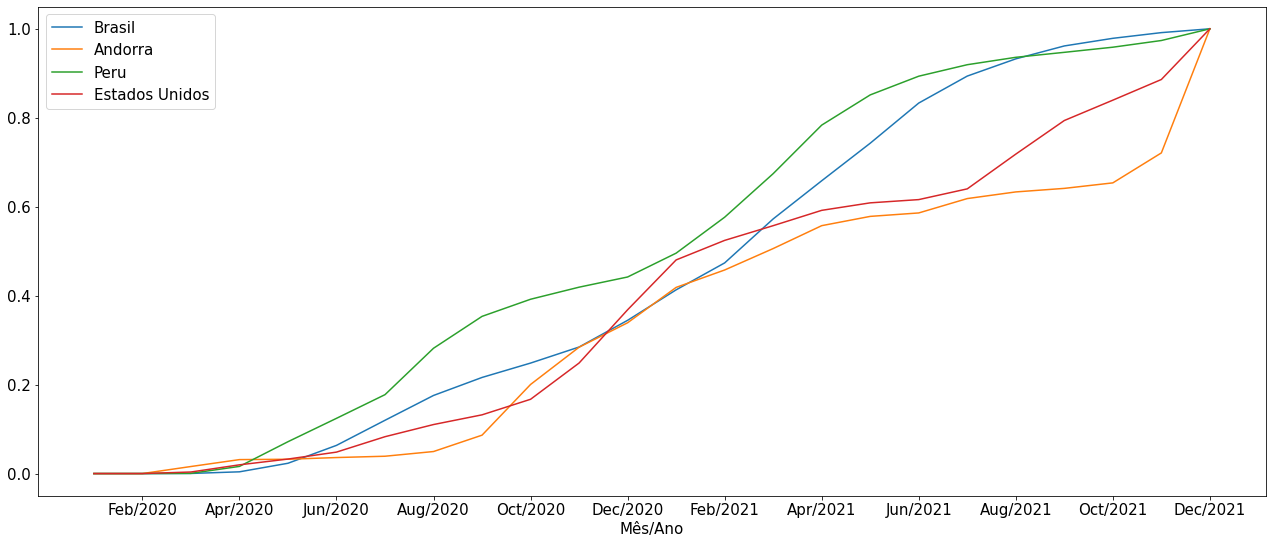

In [ ]:
x_axis = pd_casos_br['Mes_Ano'].tolist()

ax = None
for df in [pd_casos_br, pd_casos_and, pd_casos_per, pd_casos_usa]:
  ax = df.plot(ax=ax, x='Mes_Ano', y='normalizado', label=df.at[0,'nome'],
               figsize=(22,9), fontsize = 15)

plt.plot(ax=ax)
plt.xlabel('Mês/Ano', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(range(1,len(x_axis),2), x_axis[1::2])
plt.show()

### Gráfico apresentando a progressão de casos mensais em relação ao Brasil e ao mundo

Já comparando o Brasil com o mundo todo, dentro das suas proporções, o Brasil, ao término do ano de 2021, apresentou mais tendência a se estabilizar em relação ao mundo todo, porém ao longo dos dois anos apresentou maior crescimento de forma proporcional em relação ao mundo.

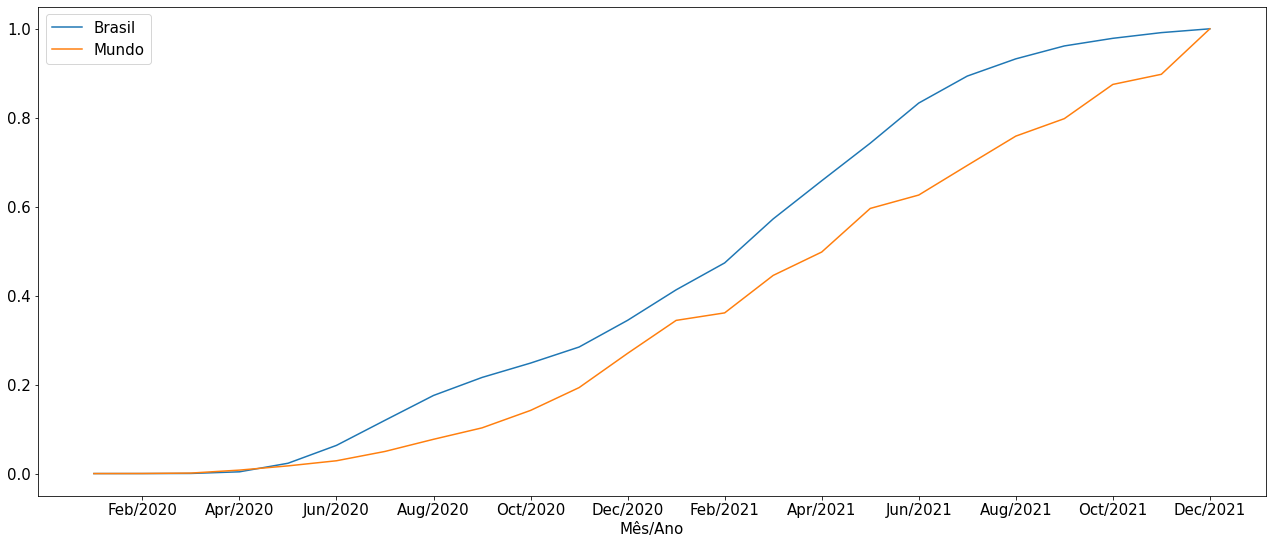

In [ ]:
x_axis = pd_casos_br['Mes_Ano'].tolist()

ax = pd_casos_br.plot(x='Mes_Ano', y='normalizado', 
                      label=pd_casos_br.at[0,'nome'])
pd_casos_mundo.plot(ax=ax, x='Mes_Ano', y='normalizado', 
                    label=pd_casos_mundo.at[0,'nome'], 
                    figsize=(22,9), fontsize = 15)

plt.xlabel('Mês/Ano', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(range(1,len(x_axis),2), x_axis[1::2])
plt.show()

### Conclusão

Por fim, por mais que o Brasil tenha apresentado maior número de mortes por casos do que os Estados Unidos que teve maior número de casos por população, o Brasil apresentou uma maior estabilidade no número de casos ao final do ano de 2021 em relação ao mundo e aos 3 países utilizados em outras comparações o que pode estar ligado ao aumento da campanha de vacinação e a sua eficácia por sua vez.